# Python Codes for Kaggle Contest 'Digit Recognizer'

This Notebook is the Python codes for Kaggle contest <a href="https://www.kaggle.com/c/digit-recognizer" target="_blank">Digit Recognizer</a>.

* Packages: Numpy, Pandas, Keras (backend: TensorFlow)
* Model: Cognitive Neural Network with Drop Outs
* Technology: Data Augmentation, Learning Rate Annealing, CPU optimization

### Performance at Submission:
<img src="https://github.com/sherrisherry/Kaggle_Starters/blob/master/images/DigitRec.JPG"></img>

### My References:
* https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
* https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99

### My Improvements:
* Changed the structure of the CNN
* Adjusted some parameters for the CNN
* Removed some redundant codes
* Added a checkpointer to save and use the best model

### Files in Digit_Recognizer:
* prediction.csv: Submission to Kaggle
* model.hdf5: Weights of The Model of The Submission
* preprocess.R: Preprocessing codes in R
* data.zip: data files

### Note about Reproducibility:
<p>Experiment shows that randomness improves model performance while reduces reproducibility of results. To make results reproducible, remove randomness by removing data augmentation and limiting CPU threads to 1.</p>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

C:\Users\Admin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# CPU optimization
config = tf.ConfigProto()
config.intra_op_parallelism_threads = 50 # set to 1 for reproducibility, increase for better performance
config.inter_op_parallelism_threads = 50 # set to 1 for reproducibility, increase for better performance
_=tf.Session(config=config)

# Set the random seed
random_seed = None # set to None for maximum randomness
np.random.seed(random_seed)

In [3]:
train = pd.read_csv("Digit_Recognizer/train.csv")
test = pd.read_csv("Digit_Recognizer/test.csv")

In [4]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train

##### checking for missing value

In [5]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

##### preparing data for modeling

In [7]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [8]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [9]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [10]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.05, random_state=random_seed)
# I used 5% of the train set as validation

##### Building the model

In [11]:
# Set the CNN model 
# my CNN architechture is In -> [Conv2D->relu]*2 -> MaxPool2D -> Dropout
# -> Conv2D->relu -> MaxPool2D -> Dropout -> Flatten -> [Dense -> Dropout]*2 -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (4,4),padding = 'valid', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [12]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [13]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

##### Learning rate annealing

In [14]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
# this annealer reduces learning rate once validation accuracy doesn't improve after 3 epochs

##### Setting up a checkpointer
<p>According to a <a herf="https://github.com/keras-team/keras/issues/2768" target="_blank">Keras Issue post</a>, Keras returns the model of the last epoch after training, not the best model. To use the best model for prediction, we need a checkpointer to save the best model.</p>

In [15]:
# Checkpointer
checkpointer = ModelCheckpoint('best_model_weights.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# This checkpointer saves the weights of the model that has the highest validation accuracy

##### Data Augmentation

In [16]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

##### Training the model

In [17]:
# set parameters for training
epochs = 20
batch_size = 106

In [18]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,checkpointer])

Epoch 1/20
 - 195s - loss: 0.4080 - acc: 0.8671 - val_loss: 0.0612 - val_acc: 0.9800

Epoch 00001: val_acc improved from -inf to 0.98001, saving model to best_model_weights.hdf5
Epoch 2/20
 - 220s - loss: 0.1275 - acc: 0.9618 - val_loss: 0.0444 - val_acc: 0.9864

Epoch 00002: val_acc improved from 0.98001 to 0.98637, saving model to best_model_weights.hdf5
Epoch 3/20
 - 222s - loss: 0.0972 - acc: 0.9711 - val_loss: 0.0399 - val_acc: 0.9906

Epoch 00003: val_acc improved from 0.98637 to 0.99061, saving model to best_model_weights.hdf5
Epoch 4/20
 - 234s - loss: 0.0846 - acc: 0.9750 - val_loss: 0.0355 - val_acc: 0.9909

Epoch 00004: val_acc improved from 0.99061 to 0.99091, saving model to best_model_weights.hdf5
Epoch 5/20
 - 258s - loss: 0.0718 - acc: 0.9786 - val_loss: 0.0307 - val_acc: 0.9918

Epoch 00005: val_acc improved from 0.99091 to 0.99182, saving model to best_model_weights.hdf5
Epoch 6/20
 - 263s - loss: 0.0668 - acc: 0.9810 - val_loss: 0.0275 - val_acc: 0.9930

Epoch 00006:

##### Examing the training process
We can see that in general accuracy improved in training.

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

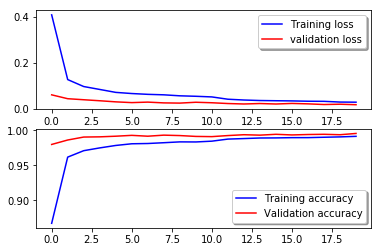

In [20]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

##### Examing model performance

In [21]:
# resuming the best weights
model.load_weights('best_model_weights.hdf5', by_name=True)

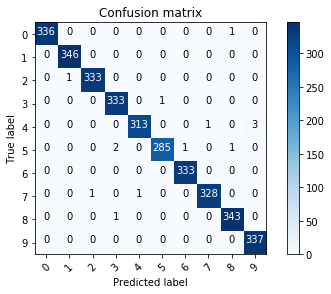

In [22]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

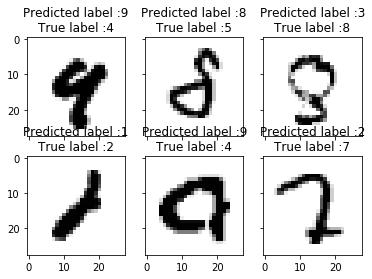

In [23]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)),cmap='gray_r')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

##### Making prediction and Generating submission

In [24]:
# predict results
results = model.predict(test)

# select the index with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

# create submission file
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)